In [1]:
!pip install celltypist

  Using cached numpy-2.1.3-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached scanpy-1.10.4-py3-none-any.whl.metadata (9.3 kB)
  Using cached leidenalg-0.10.2-cp38-abi3-win_amd64.whl.metadata (10 kB)
  Using cached igraph-0.11.8-cp39-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached charset_normalizer-3.4.0-cp312-cp312-win_amd64.whl.metadata (34 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
  Using cached anndata-0.11.1-py3-none-

In [1]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import celltypist
from celltypist import models

In [ ]:
MODEL = 'Human_Placenta_Decidua.pkl'
dataset_type = 'heca_vsdisease'
h5ad_filename = 'scvi_integrated.h5ad'

current_directory = pathlib.Path.cwd()
module_directory = current_directory.parent.parent

output_path = module_directory / 'output'
scrna_path = output_path/ 'integrated_scRNA'/ dataset_type /h5ad_filename

cell_typist_directory = output_path / 'cell_typist' /dataset_type


for path in [scrna_path, cell_typist_directory]:
    if not path.exists():
        print(f"Directory {path} does not exist. Creating it now...")
        path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"Directory {path} already exists.")

Directory d:\Coding\comp_bio\endometrial_analysis\output\integrated_scRNA\heca_vsdisease\scvi_integrated.h5ad already exists.
Directory d:\Coding\comp_bio\endometrial_analysis\output\cell_typist\heca_vsdisease does not exist. Creating it now...


In [3]:
adata_heca = sc.read(scrna_path)

In [4]:
adata_heca

AnnData object with n_obs × n_vars = 114459 × 4000
    obs: 'dataset', 'Menstrual Cycle Stage', 'Disease State', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scvi_corr', 'leiden_scvi_euc'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'Disease State_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'leiden_scvi_corr', 'leiden_scvi_corr_colors', 'leiden_scvi_euc', 'leiden_scvi_euc_colors', 'log1p', 'neighbors', 'neighbors_corr', 'neighbors_euc', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_scVI_MDE', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scvi_expr'
    obsp: 'connectivities', 'distances', 'neighbors_corr_connectivities', 'neighbors_corr_distances', 'neighbors_euc_connectivities', 'neighbors_euc_distances'

In [5]:
type(adata_heca.X)

numpy.ndarray

In [6]:
print(adata_heca.layers.keys())  # List all layers
print(adata_heca.uns)  # Unstructured metadata
print(adata_heca.obs)  # Cell-level metadata
print(adata_heca.var) 

KeysView(Layers with keys: counts, scvi_expr)
{'Disease State_colors': array(['#4c72b0', '#dd8452'], dtype=object), '_scvi_manager_uuid': '03d2659f-3b25-43b7-b800-b5f38fb1d04a', '_scvi_uuid': 'dff0ed86-bff0-477b-925a-fe883c8a8810', 'dataset_colors': array(['#1f77b4', '#ff7f0e', '#279e68', '#d62728', '#aa40fc', '#8c564b',
       '#e377c2', '#b5bd61', '#17becf', '#aec7e8', '#ffbb78', '#98df8a',
       '#ff9896'], dtype=object), 'hvg': {'flavor': 'seurat_v3'}, 'leiden_scvi_corr': {'params': {'n_iterations': np.int64(-1), 'random_state': np.int64(0), 'resolution': np.float64(1.2)}}, 'leiden_scvi_corr_colors': array(['#023fa5', '#7d87b9', '#bec1d4', '#d6bcc0', '#bb7784', '#8e063b',
       '#4a6fe3', '#8595e1', '#b5bbe3', '#e6afb9', '#e07b91', '#d33f6a',
       '#11c638', '#8dd593', '#c6dec7', '#ead3c6', '#f0b98d', '#ef9708',
       '#0fcfc0', '#9cded6', '#d5eae7', '#f3e1eb', '#f6c4e1', '#f79cd4',
       '#7f7f7f', '#c7c7c7'], dtype=object), 'leiden_scvi_euc': {'params': {'n_iterations': np.

In [34]:
total_counts_per_cell =adata_heca.layers["scvi_expr"].sum(axis=1)

# Normalize to 10,000 counts per cell
normalized_expression = adata_heca.layers["scvi_expr"] / total_counts_per_cell[:, None] * 10000

# Apply log1p transformation
log_normalized_expression = np.log1p(normalized_expression)

In [37]:
original_normalized_expression = np.expm1(log_normalized_expression)

# Sum the values across each row (axis=1) to get the total expression per cell
total_expression_per_cell = original_normalized_expression.sum(axis=1)
print(total_expression_per_cell[:5])  # Print first 5 total expression values

[10000.    10000.    10000.    10000.001 10000.   ]


In [38]:
adata_heca.layers['oldX'] = adata_heca.X.copy()  # Store .X as .oldX in layers
adata_heca.X = log_normalized_expression

In [10]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json


📚 Total models in list: 52
📂 Storing models in C:\Users\Olaf\.celltypist\data\models
💾 Downloading model [1/52]: Immune_All_Low.pkl
💾 Downloading model [2/52]: Immune_All_High.pkl
💾 Downloading model [3/52]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/52]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/52]: Adult_Human_MTG.pkl
💾 Downloading model [6/52]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/52]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/52]: Adult_Human_Skin.pkl
💾 Downloading model [9/52]: Adult_Mouse_Gut.pkl
💾 Downloading model [10/52]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [11/52]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [12/52]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [13/52]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [14/52]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [15/52]: COVID19_Immune_Landscape.pkl
💾 Downloading model [16/52]: Cells_Adult_Breast.pkl
💾 Downloading model [17/52]: C

In [11]:
models.models_path

'C:\\Users\\Olaf\\.celltypist\\data\\models'

In [12]:
model = models.Model.load(model = MODEL)

In [13]:
model

CellTypist model with 32 cell types and 4251 features
    date: 2024-06-24 12:24:39.703109
    details: cell types from first-trimester human placentas with matched maternal blood and decidua
    source: https://doi.org/10.1038/s41586-018-0698-6
    version: v1
    cell types: DC1, DC2, ..., fFB2
    features: TNMD, FGR, ..., IGLL5

In [14]:
model.cell_types

array(['DC1', 'DC2', 'EVT', 'Endo (f)', 'Endo (m)', 'Endo L', 'Epi1',
       'Epi2', 'Granulocytes', 'HB', 'ILC3', 'MO', 'NK CD16+', 'NK CD16-',
       'Plasma', 'SCT', 'Tcells', 'VCT', 'dM1', 'dM2', 'dM3', 'dNK p',
       'dNK1', 'dNK2', 'dNK3', 'dP1', 'dP2', 'dS1', 'dS2', 'dS3', 'fFB1',
       'fFB2'], dtype=object)

In [39]:
predictions = celltypist.annotate(adata_heca, model = MODEL, majority_voting = True)

🔬 Input data has 114459 cells and 4000 genes
🔗 Matching reference genes in the model
🧬 1307 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


In [40]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
AGGTAGGTCCTCACTG-1,Epi2,195,Epi2
AGCGTATCAGAAGTTA-1,Epi2,135,Epi2
CCCATTGCACATACGT-1,Epi2,113,Epi2
ATTCGTTTCCCATGGG-1,Epi2,245,Epi2
GCACATATCTGGGCCA-1,Epi2,247,Epi2
...,...,...,...
TTTGTTGCACGGGCTT-1,Epi2,221,Epi2
TTTGTTGCAGGTTCAT-1,Epi2,292,Epi2
TTTGTTGCATACCGTA-1,Epi2,27,Epi2
TTTGTTGGTATGCTAC-1,Epi2,214,Epi2


In [41]:
adata_predictions = predictions.to_adata()

In [42]:
adata_predictions.obs

,dataset,Menstrual Cycle Stage,Disease State,n_genes_by_counts,total_counts,total_counts_MT,pct_counts_MT,n_genes,_scvi_batch,_scvi_labels,leiden_scvi_corr,leiden_scvi_euc,predicted_labels,majority_voting,conf_score,over_clustering
AGGTAGGTCCTCACTG-1,UA_Endo10281925_FX1101,Proliferative,endometriosis,2053,3284.0,2.0,0.060901,2053,0,0,10,10,Epi2,Epi2,1.000000,195
AGCGTATCAGAAGTTA-1,UA_Endo10281925_FX1101,Proliferative,endometriosis,2200,3445.0,6.0,0.174165,2200,0,0,10,1,Epi2,Epi2,1.000000,135
CCCATTGCACATACGT-1,UA_Endo10281925_FX1101,Proliferative,endometriosis,3130,6340.0,2.0,0.031546,3130,0,0,3,2,Epi2,Epi2,1.000000,113
ATTCGTTTCCCATGGG-1,UA_Endo10281925_FX1101,Proliferative,endometriosis,2419,4101.0,11.0,0.268227,2419,0,0,3,2,Epi2,Epi2,1.000000,245
GCACATATCTGGGCCA-1,UA_Endo10281925_FX1101,Proliferative,endometriosis,3015,5605.0,1.0,0.017841,3015,0,0,3,2,Epi2,Epi2,1.000000,247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCACGGGCTT-1,UA_Endo9426399_FX1146,Proliferative,normal,2296,5052.0,759.0,15.023753,2296,12,0,16,6,Epi2,Epi2,0.999987,221
TTTGTTGCAGGTTCAT-1,UA_Endo9426399_FX1146,Proliferative,normal,3530,8660.0,791.0,9.133949,3530,12,0,2,15,Epi2,Epi2,0.999994,292
TTTGTTGCATACCGTA-1,UA_Endo9426399_FX1146,Proliferative,normal,2791,7051.0,1309.0,18.564743,2791,12,0,16,13,Epi2,Epi2,0.955900,27
TTTGTTGGTATGCTAC-1,UA_Endo9426399_FX1146,Proliferative,normal,1932,3902.0,638.0,16.350590,1932,12,0,16,11,Epi2,Epi2,0.999993,214


In [43]:
sc.tl.umap(adata_predictions)

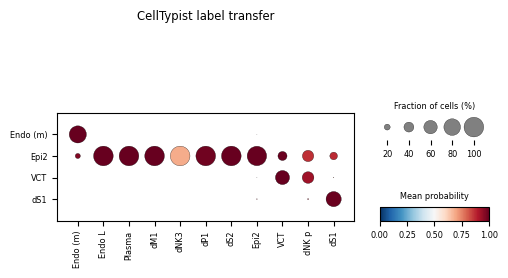

In [45]:
celltypist.dotplot(predictions, use_as_reference = 'predicted_labels', use_as_prediction = 'majority_voting')

In [46]:
output_file = cell_typist_directory/"celltypist_annotated.h5ad"
adata_heca.write(output_file)


In [47]:
str(adata_heca)

"AnnData object with n_obs × n_vars = 114459 × 4000\n    obs: 'dataset', 'Menstrual Cycle Stage', 'Disease State', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden_scvi_corr', 'leiden_scvi_euc', 'predicted_labels', 'majority_voting', 'conf_score', 'over_clustering'\n    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'\n    uns: 'Disease State_colors', '_scvi_manager_uuid', '_scvi_uuid', 'dataset_colors', 'hvg', 'leiden_scvi_corr', 'leiden_scvi_corr_colors', 'leiden_scvi_euc', 'leiden_scvi_euc_colors', 'log1p', 'neighbors', 'neighbors_corr', 'neighbors_euc', 'pca', 'umap', 'over_clustering', 'predicted_labels_colors', 'majority_voting_colors'\n    obsm: 'X_pca', 'X_scVI', 'X_scVI_MDE', 'X_umap'\n    varm: 'PCs'\n    layers: 'counts', 'scvi_expr', 'oldX'\n    obsp: 'conn